In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm


import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from convnext import get_convnext
from imagenet_val import ValData
from interp_utils import remove_hooks, register_hook, TensorHistogramObserver


val = ValData()
model = get_convnext()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval().to(device);


/home/noa/.miniconda/envs/convnext/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [365]:
# Store bin counts for each neuron in each layer on the validation set



BATCH_SIZE = 10



hist_observer = TensorHistogramObserver(min=-10, max=4, bin_width=0.05, tensor_shape=(18, 1536))

def cache_preact(module, input, output):
    module.cache['preact'] = input[0]

remove_hooks(model, quiet=True)
for layer_idx in range(18):
    register_hook(model.blocks[layer_idx].act, cache_preact)


def get_cached_preacts(model):
    preacts = []
    for layer_idx in range(18):
        preacts.append(model.blocks[layer_idx].act.cache['preact'])
    preacts = torch.stack(preacts, dim=0)
    return preacts

pbar = tqdm(val.as_batches(BATCH_SIZE), total=len(val)//BATCH_SIZE)
for batch in pbar:
    with torch.no_grad():
        model(batch.data.to(device))
        preacts = get_cached_preacts(model)
        
        # reshape preacts to be of shape (layer, neuron, -1) for hist_observer
        preacts = preacts.transpose(1, -1).reshape(18, 1536, -1)
        hist_observer.update(preacts)

  1%|          | 51/5000 [00:40<1:05:27,  1.26it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/home/noa/.miniconda/envs/convnext/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_10999/785254793.py", line 36, in <module>
    hist_observer.update(preacts)
  File "/home/noa/interp/convnext-interp/interp_utils/general_utils.py", line 110, in update
    obs = obs.detach().cpu()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/noa/.miniconda/envs/convnext/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2052, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/noa/.miniconda/envs/convnext/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/noa/.miniconda/envs/convnext/lib/python3.10/site-packages/

In [2]:
# Load existing data
hist_observer = TensorHistogramObserver(min=-10, max=4, bin_width=0.2, tensor_shape=(18, 1536))
neuron_bin_counts = torch.load('neuron_bin_counts.pt')
hist_observer.counts = neuron_bin_counts

tensor([  66,  270,  835,  840, 1523,  967,  424, 1364,   30,  766,   60,  508,
        1173,  954,  676,  275])

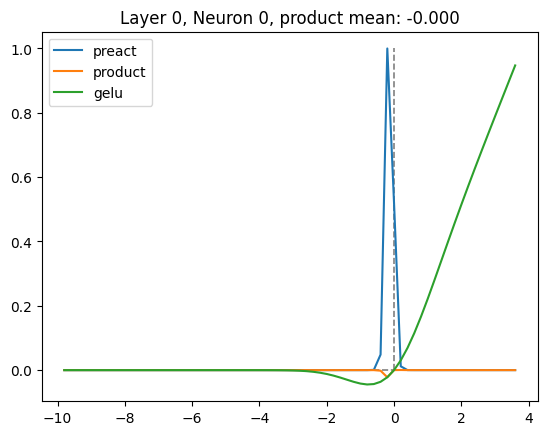

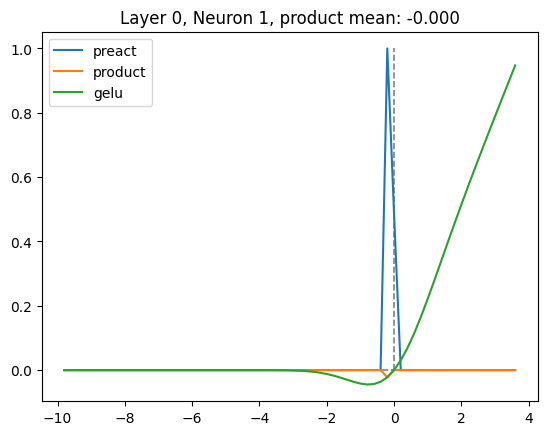

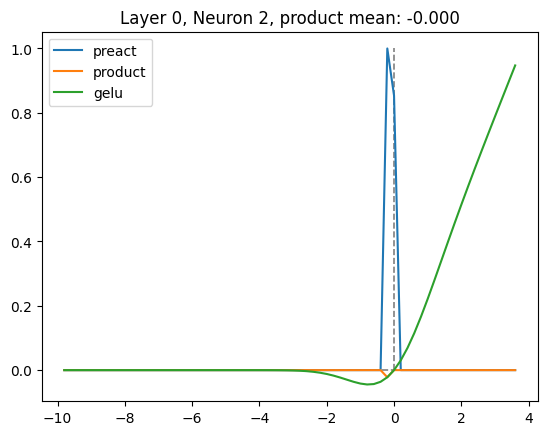

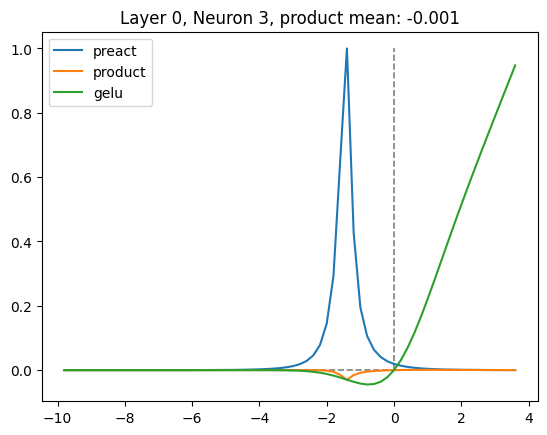

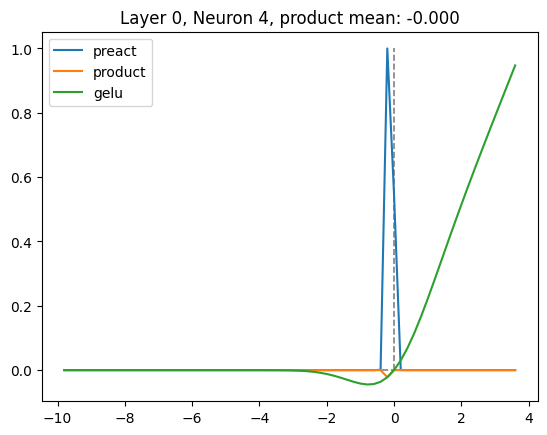

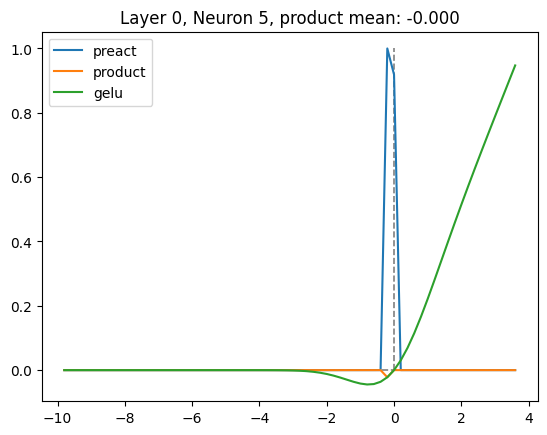

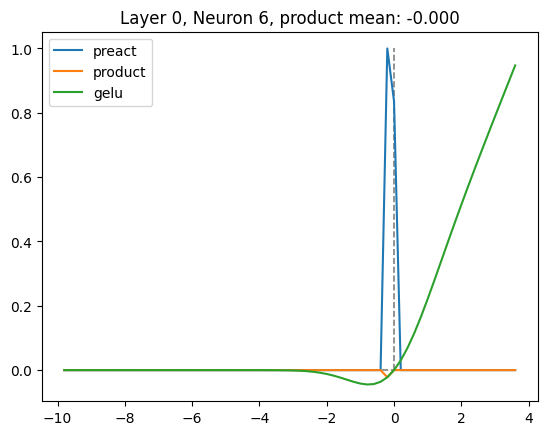

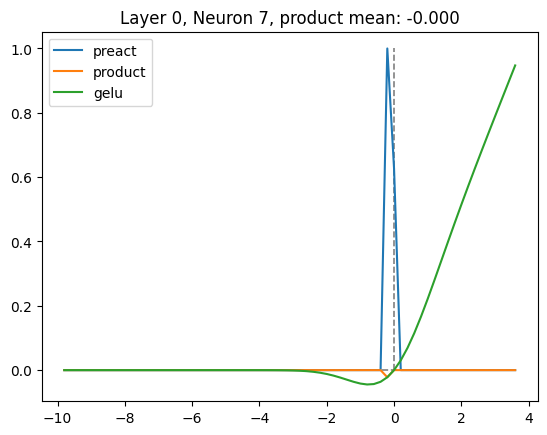

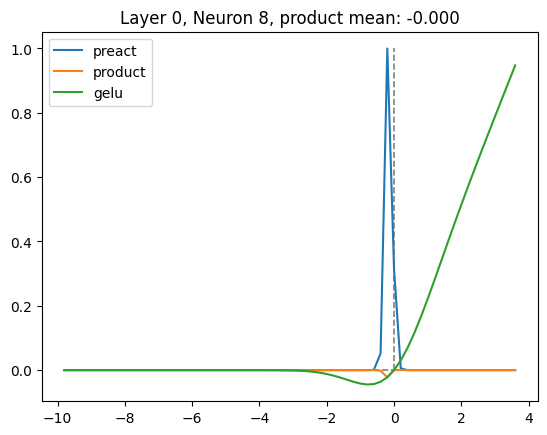

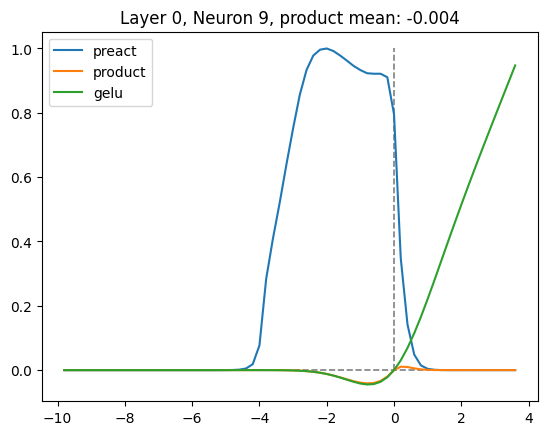

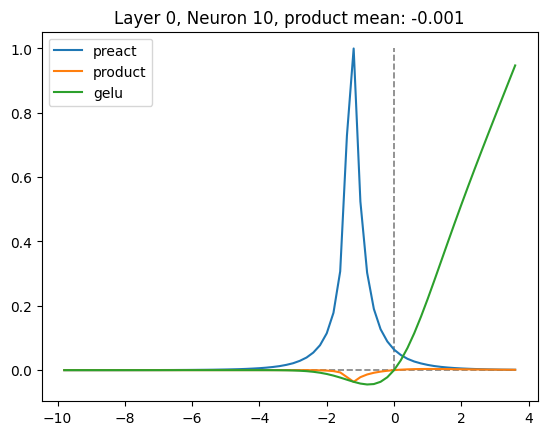

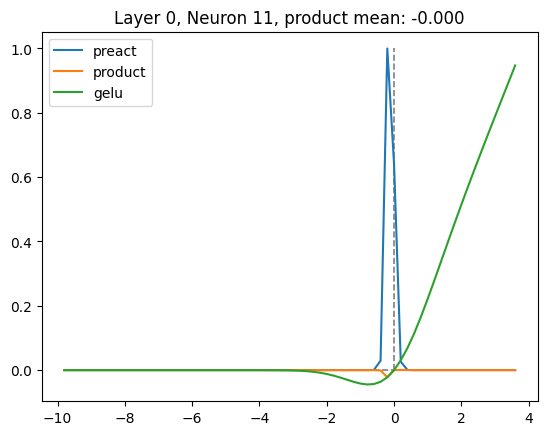

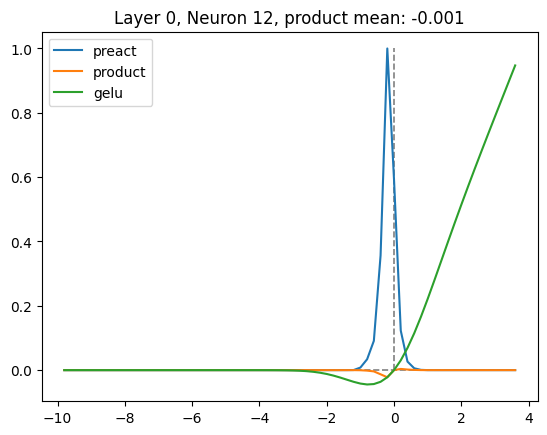

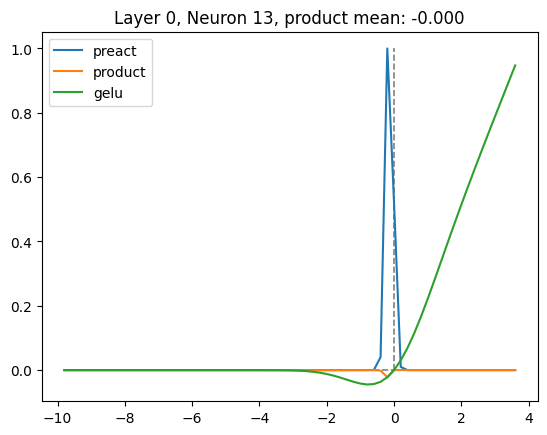

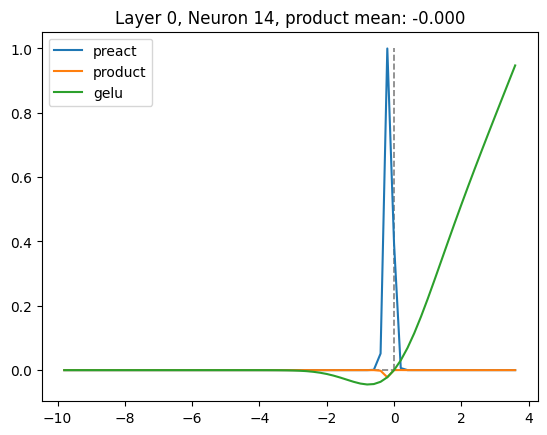

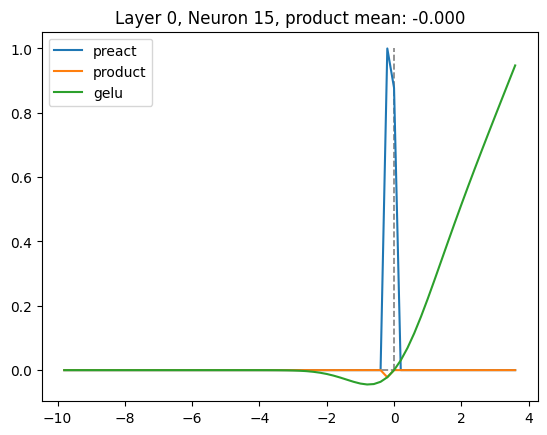

In [14]:
CLIP_EDGES = True
LAYER = 0


for neuron_idx in torch.randint(0, 1536, (16,)):
    boundaries = hist_observer.boundaries

    hist_counts = hist_observer.counts[LAYER][neuron_idx]
    hist_counts = (hist_counts / hist_counts.max())
    boundaries = boundaries[0:-1]

    gelu_y = F.gelu(boundaries)
    gelu_y = (gelu_y / gelu_y.max())

    if CLIP_EDGES is True:
        boundaries = boundaries[1:-1]
        hist_counts = hist_counts[1:-1]
        gelu_y = gelu_y[1:-1]

    hist_counts = hist_counts / hist_counts.max()

    product = gelu_y*hist_counts

    # zero line and y axis
    plt.plot([boundaries[0], boundaries[-1]], [0, 0], color="grey", linestyle="--", label="_zero", linewidth=1.2)
    plt.plot([0, 0], [0, 1], color="grey", linestyle="--", label="_yaxis", linewidth=1.2)

    plt.plot(boundaries, hist_counts, label="preact")
    plt.plot(boundaries, product, label="product")
    plt.plot(boundaries, gelu_y, label="gelu")
     
    # add title
    plt.title(f"Layer {LAYER}, Neuron {neuron_idx}, product mean: {product.mean():.3f}")

    plt.legend()
    plt.show()